# Classificação de textos com spaCy

## 01. importação e instalação das bibliotecas

In [57]:
!pip install spacy==2.2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached spacy-2.2.3.tar.gz (5.9 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [58]:
# Temporário por problemas no Colab
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [59]:
!python3 -m spacy download pt

2023-06-21 23:38:05.483602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the
full pipeline package name 'pt_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 29.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [60]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np

## 02. Carregamento da base de dados

In [61]:
base_dados = pd.read_csv('/content/drive/MyDrive/Machine Learning e Data Science com Python de A a Z/Bases de dados/base_treinamento.txt', encoding='utf-8')

In [62]:
base_dados.shape

(196, 2)

In [63]:
base_dados.sample(5)


,texto,emocao
77,me dedico muito naquilo que faço,alegria
118,não entro lá é um lugar muito perigoso,medo
34,ele é realmente fiel a mim,alegria
108,anseio por seus próximos trabalhos,alegria
181,isso não é remedio não me matem,medo


<Axes: xlabel='emocao', ylabel='count'>

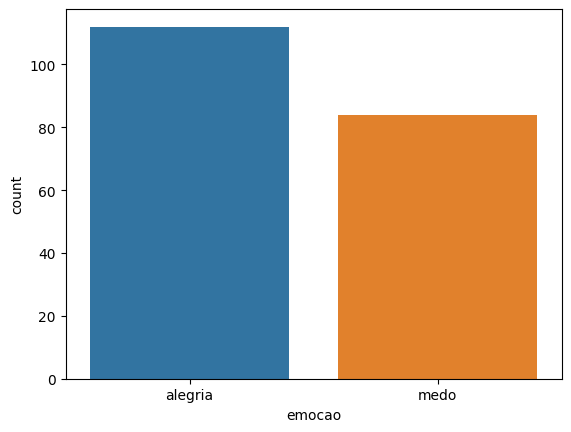

In [64]:
# COntando quantos registros de cada classe
sns.countplot(x='emocao', data=base_dados, label='Contagem')

## 03. Função pre-processamento

In [65]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS

In [67]:

pln = spacy.load("pt_core_news_sm")

In [68]:
def preprocessamento(texto):
  texto = texto.lower()
  documento = pln(texto)

  lista = []
  for token in documento:
    #lista.append(token.text)
    lista.append(token.lemma_)

  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista


In [69]:
texto = 'estou aprendendo procesamento de linguagem natual, curso em udemy, nota 10!!!!'
texto_novo = preprocessamento(texto)
print(texto_novo)

aprender procesamento linguagem natual curso udemy nota


## 04. Pre-processamento da base de dados

### limpeza dos dados

In [70]:
base_dados['texto'] = base_dados['texto'].apply(preprocessamento)

In [71]:
base_dados

,texto,emocao
0,trabalho agradável,alegria
1,gosto ficar em o aconchego,alegria
2,fiz adesão a o curso hoje,alegria
3,admirar,alegria
4,adorar,alegria
...,...,...
191,chocado amedrontar assassinato brutal,medo
192,preciso afugentar ímpeto medo de o inferno,medo
193,político força afugentar amedrontar,medo
194,objetivo de isso amedrontar,medo


### Tratamento da classe

In [72]:
 exemplo_base_dados = [['este trabalho é agradavel', {'ALEGRIA': True, "MEDO": False}],
                       ['este lugar continua assustador', {'ALEGRIA': False, "MEDO": True}]
                       ]

In [73]:
exemplo_base_dados[0]

['este trabalho é agradavel', {'ALEGRIA': True, 'MEDO': False}]

In [74]:
exemplo_base_dados[0][0]

'este trabalho é agradavel'

In [75]:
exemplo_base_dados[0][1]

{'ALEGRIA': True, 'MEDO': False}

In [76]:
base_dados_final = []
for texto, emocao in zip(base_dados['texto'], base_dados['emocao']):
  if emocao == 'alegria':
    dic = ({'ALEGRIA': True, 'MEDO': False})
  elif emocao == 'medo':
    dic = ({'ALEGRIA': False, 'MEDO': True})

  base_dados_final.append([texto, dic.copy()])

In [77]:
len(base_dados_final)

196

In [78]:
base_dados_final[0]

['trabalho agradável', {'ALEGRIA': True, 'MEDO': False}]

## 05. Criação do classificador


In [79]:
modelo = spacy.blank('pt') # é uma rede neural
textcat = modelo.add_pipe("textcat")
textcat.add_label("ALEGRIA")
textcat.add_label("MEDO")
historico = []


In [80]:
# Treinamento
from spacy.training import Example
modelo.begin_training()
for epoca in range(1000):
  random.shuffle(base_dados_final) # Pra misturar os dados
  losses = {} # Controlar o erro
  for batch in spacy.util.minibatch(base_dados_final, 30): # ajustaremos os pesos da rede neural a cada 30 registros
    textos = [modelo(texto) for texto, entities in batch] # Vai pegar todos os textos da batch e submeter ao modelo
    annotations = [{'cats':entities for texto, entities in batch}] # Vai pegar as categorias dos textos
    examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(
            textos, annotations
        )]
    modelo.update(examples, losses=losses)
  if epoca % 100 ==0:
    print(losses)
    historico.append(losses)

{'textcat': 1.7432493567466736}
{'textcat': 1.6665212586522102}
{'textcat': 1.028866053558886}
{'textcat': 2.506326697766781}
{'textcat': 2.3617293145507574}
{'textcat': 3.004909610375762}
{'textcat': 2.177050918340683}
{'textcat': 2.0320933163166046}
{'textcat': 2.311014488339424}
{'textcat': 1.4269339591264725}


In [81]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [82]:
historico_loss = np.array(historico_loss)
historico_loss

array([1.74324936, 1.66652126, 1.02886605, 2.5063267 , 2.36172931,
       3.00490961, 2.17705092, 2.03209332, 2.31101449, 1.42693396])

Text(0, 0.5, 'Erro')

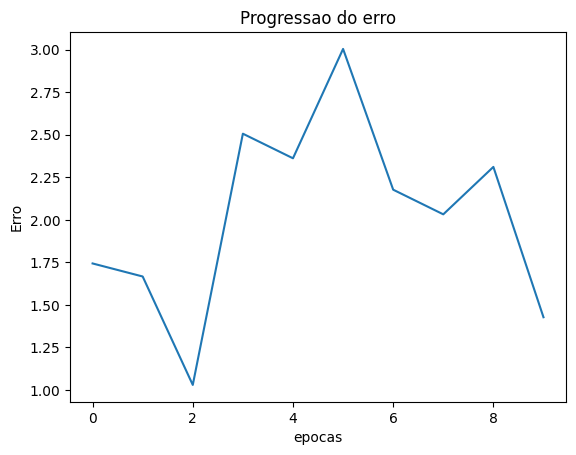

In [83]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressao do erro')
plt.xlabel("epocas")
plt.ylabel('Erro')

In [84]:
modelo.to_disk('Modelo')

## Testes com uma frase


In [85]:
texto_positivo = 'eu adoro cor dos seus olhos'

In [86]:
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'adorar cor de o olho'

In [87]:
previsao = modelo(texto_positivo)
previsao

adorar cor de o olho

In [88]:
previsao.cats

{'ALEGRIA': 0.6533899307250977, 'MEDO': 0.34661009907722473}

In [90]:
texto_negativo = 'eu estou com medo dele'
texto_negativo = preprocessamento(texto_negativo)
previsao = modelo(texto_negativo)
previsao.cats

{'ALEGRIA': 0.6544044613838196, 'MEDO': 0.3455955386161804}

## Avaliação do modelo

In [94]:
previsoes = []
for texto in base_dados['texto']:
  previsao = modelo(texto)
  previsoes.append(previsao.cats)

previsoes_final = []
for previsao in previsoes:
  if previsao['ALEGRIA'] > previsao['MEDO']:
    previsoes_final.append('alegria')
  else:
    previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final)

In [95]:
previsoes_final


array(['alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 

In [101]:
respostas_real = base_dados['emocao'].values
respostas_real

array(['alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 

In [102]:
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy_score(respostas_real, previsoes_final)

0.5714285714285714

In [104]:
cm = confusion_matrix(respostas_real, previsoes_final)
cm

array([[112,   0],
       [ 84,   0]])

## Avalisação base dados teste

In [106]:
base_dados_teste = pd.read_csv('/content/drive/MyDrive/Machine Learning e Data Science com Python de A a Z/Bases de dados/base_teste.txt', encoding = 'utf-8')
base_dados_teste.sample(5)

,texto,emocao
26,sua bondade é cativante,alegria
36,você será muito amado meu filho,alegria
27,estou despreocupada,alegria
3,sou muito afortunado,alegria
31,somos estimados por nossa família,alegria


In [107]:
base_dados_teste['texto'] = base_dados_teste['texto'].apply(preprocessamento)
base_dados_teste.head()

,texto,emocao
0,precisar pagar ingresso,alegria
1,ajeitar ficar,alegria
2,fortuna ultrapassar,alegria
3,afortunar,alegria
4,benéfico medida,alegria


In [109]:
previsoes = []
for texto in base_dados_teste['texto']:
  previsao = modelo(texto)
  previsoes.append(previsao.cats)

previsoes_final = []
for previsao in previsoes:
  if previsao['ALEGRIA'] > previsao['MEDO']:
    previsoes_final.append('alegria')
  else:
    previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final)

In [110]:
respostas_real = base_dados_teste['emocao'].values

accuracy_score(respostas_real, previsoes_final)

0.5714285714285714

In [111]:
cm = confusion_matrix(respostas_real, previsoes_final)
cm

array([[48,  0],
       [36,  0]])